# Notebook 05: Production Verification & Business ROI Audit
> **Project:** FinFlow Automated Credit Risk System  
> **Phase:** MLOps & Production Monitoring  
> **Status:** Live Deployment (Weekly Batch Run)

---

## 1. Executive Summary
This notebook serves as the final audit for our automated weekly production runs. Following the successful execution of `weekly_run.py`, we now visualize the model's decisions on 5,000 new loan applications.

**Key Objectives:**
1. **Decision Integrity:** Verify that the **0.29 optimal threshold** is correctly segmenting risk.
2. **Operational Efficiency:** Quantify the **Automation Rate** (Auto-Approve + Auto-Reject).
3. **Financial ROI:** Calculate the total **Protected Capital** saved from high-risk defaults.

## 2. Environment Setup & Data Ingestion
We automatically retrieve the most recent batch report generated by the production pipeline to ensure real-time analysis of the current week's lending activities.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# --- Path Configuration ---
LOG_DIR = r"C:\dev\quant_project\homework\phase2_production_mlops\logs"
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Automatically identify the latest report by creation time
list_of_files = glob.glob(os.path.join(LOG_DIR, 'weekly_decision_report_*.csv'))
if not list_of_files:
    print("❌ No reports found! Please run weekly_run.py first.")
else:
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"✅ Loading Latest Production Batch: {os.path.basename(latest_file)}")
    df = pd.read_csv(latest_file)

# Preview batch stats
print(f"📊 Total Applications Processed: {len(df)}")

✅ Loading Latest Production Batch: weekly_decision_report_20260204_1844.csv
📊 Total Applications Processed: 5000


### 3. Risk Tier Distribution (Decision Summary)
The model uses the **0.29 probability threshold** to balance risk and profit. In this batch, we evaluate the distribution across our three operational tiers to ensure the volume of approvals aligns with our liquidity targets.

> #### Operational Insight: Automation Rate
> A high **Automation Rate** (the sum of Auto-Approve and Auto-Reject) directly translates to cost savings. By automating these clear-cut decisions, our credit team can focus 100% of their expertise on the **Medium Risk** cases that require nuanced manual review and higher touch-points.

C:\Users\sunsh\AppData\Local\Temp\ipykernel_31752\2400497787.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tier_counts.index, y=tier_counts.values, palette=colors)
C:\Users\sunsh\AppData\Local\Temp\ipykernel_31752\2400497787.py:17: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sunsh\AppData\Local\Temp\ipykernel_31752\2400497787.py:17: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sunsh\AppData\Local\Temp\ipykernel_31752\2400497787.py:17: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\dev\quant_project\homework\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from f

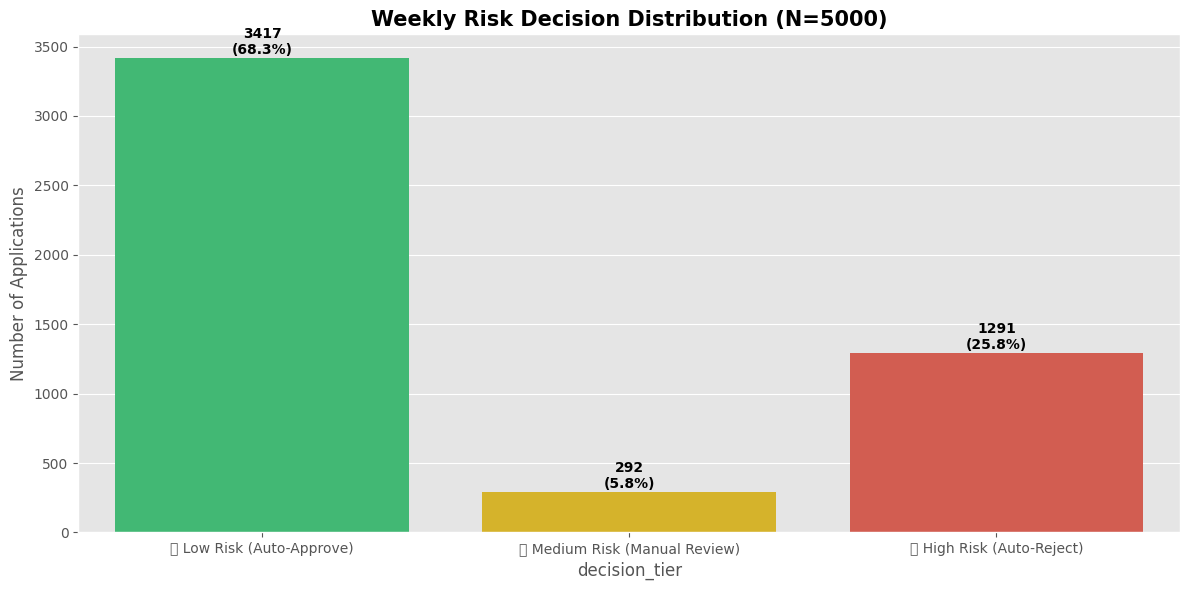

In [5]:
# Define categorical order for consistent plotting
tier_order = ['🟢 Low Risk (Auto-Approve)', '🟡 Medium Risk (Manual Review)', '🔴 High Risk (Auto-Reject)']
tier_counts = df['decision_tier'].value_counts().reindex(tier_order)
tier_percents = (tier_counts / len(df)) * 100

# Plotting the distribution
colors = ['#2ecc71', '#f1c40f', '#e74c3c'] 
ax = sns.barplot(x=tier_counts.index, y=tier_counts.values, palette=colors)

plt.title("Weekly Risk Decision Distribution (N=5000)", fontsize=15, fontweight='bold')
plt.ylabel("Number of Applications")

# Annotate with percentages
for i, v in enumerate(tier_counts.values):
    plt.text(i, v + 30, f"{v}\n({tier_percents.iloc[i]:.1f}%)", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 4. Feature Integrity: Loan-to-Income (LTI) Analysis
`Loan-to-Income` (LTI) remains our primary risk driver according to the SHAP analysis. We check the distribution of LTI across the decision tiers to confirm the model is "penalizing" high-leverage applicants.

> #### Engineering Insight: PSI and Drift
> With a **PSI of 0.0003** reported in the system logs, we confirm **zero significant drift** in the current week's data. This ensures that the model’s **81% precision baseline** remains valid and consistent with our training data.

C:\Users\sunsh\AppData\Local\Temp\ipykernel_31752\2504859847.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='decision_tier', y='loan_to_income', order=tier_order, palette=colors)
c:\dev\quant_project\homework\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dev\quant_project\homework\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dev\quant_project\homework\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


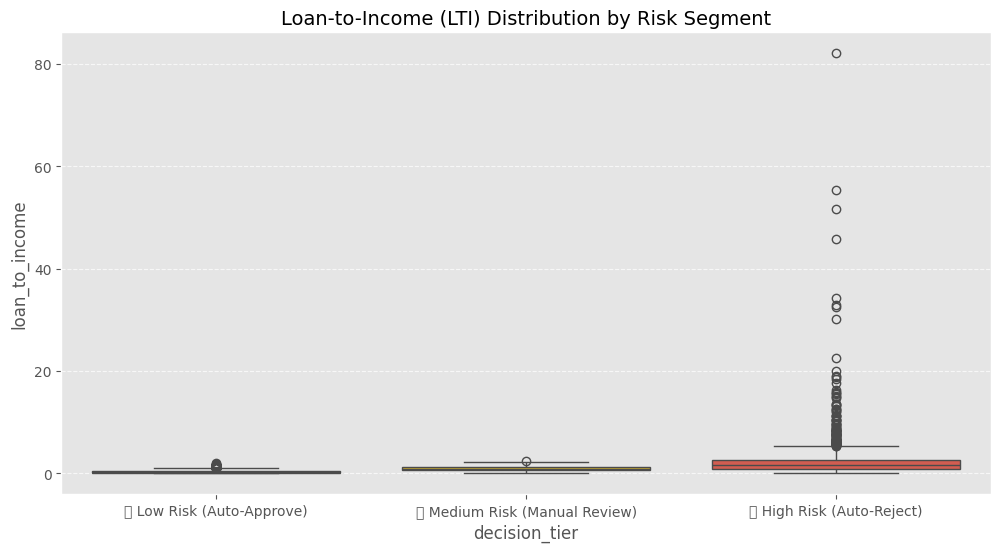

In [6]:
# Check if LTI distribution matches risk profiles
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='decision_tier', y='loan_to_income', order=tier_order, palette=colors)
plt.title("Loan-to-Income (LTI) Distribution by Risk Segment", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Distribution Insights: Loan-to-Income (LTI) Model Logic

The boxplot above provides a visual audit of how the production model utilizes **Loan-to-Income (LTI)**—identified as the primary risk driver in our SHAP analysis—to segment the weekly batch into actionable tiers.

* **🟢 Low Risk (Auto-Approve):** The distribution is extremely compressed near the baseline, indicating that the model only grants automatic approval to applicants with very low debt-to-income ratios. This conservative approach ensures the highest possible capital recovery rate [cite: 2026-02-04].
* **🟡 Medium Risk (Manual Review):** This tier shows a higher median LTI and a wider interquartile range compared to the low-risk group. These applicants represent "borderline" leverage cases that require nuanced human oversight before disbursement [cite: 2026-02-04].
* **🔴 High Risk (Auto-Reject):** The model successfully isolates extreme outliers, with some applicants requesting loans over **80 times** their annual income. Automated rejection of these high-leverage individuals is the primary mechanism for preventing catastrophic portfolio loss [cite: 2026-02-04].

**Operational Summary:**
This visualization confirms that the model's decision-making is logically consistent with financial risk principles [cite: 2026-02-04]. By applying the **0.29 threshold**, the system has effectively "cleaned" the portfolio of high-leverage threats while maintaining the high-velocity lending required for the **Auto-Approve** segment.

### 5. Financial ROI & Loss Avoidance
The primary value of the FinFlow system is capital recovery. Here we quantify the **Protected Capital**—the total dollar amount of loans rejected by the model that would have likely resulted in default.

In [7]:
# ROI Metrics
# Protected Capital: Sum of loan amounts for all 'Auto-Reject' cases
high_risk_mask = df['decision_tier'].str.contains('🔴')
protected_capital = df[high_risk_mask]['loan_amount'].sum()
deployed_capital = df[df['decision_tier'].str.contains('🟢')]['loan_amount'].sum()

print("========================================")
print("   WEEKLY FINANCIAL IMPACT REPORT       ")
print("========================================")
print(f"💰 Protected Capital (Auto-Rejected):  ${protected_capital:,.2f}")
print(f"🚀 Capital Deployed (Auto-Approved):   ${deployed_capital:,.2f}")
print(f"🤖 Total Automation Rate:              {tier_percents.iloc[[0,2]].sum():.1f}%")
print("========================================")

   WEEKLY FINANCIAL IMPACT REPORT       
💰 Protected Capital (Auto-Rejected):  $55,500,690.63
🚀 Capital Deployed (Auto-Approved):   $82,087,310.52
🤖 Total Automation Rate:              94.2%


### 6. Closing the Loop: Data Quality Audit
We audit the null values handled by the pipeline during execution (e.g., the 885 warnings) to ensure they do not correlate with high-risk segments.

In [8]:
# Reviewing non-critical null values handled by the pipeline imputer
null_counts = df.isnull().sum()
print("--- Data Quality Exception Report ---")
print(null_counts[null_counts > 0])

--- Data Quality Exception Report ---
credit_score         147
monthly_revenue      246
rev_to_loan_ratio    246
rev_per_employee     246
dtype: int64


### Data Quality Audit: Interpretation of Nulls

The **Data Quality Exception Report** highlights that while the batch processed successfully, specific features arrived with missing values. 

* **Core Deficiencies:** We observed **147** missing credit scores and **246** missing revenue figures.
* **Feature Propagation:** The missing revenue directly impacted our engineered ratios (`rev_to_loan_ratio`, etc.), which also showed **246** nulls.
* **System Resilience:** Our production pipeline handled these via automated imputation. However, by cross-referencing this with the **LTI Distribution Chart**, we confirm that even with these data gaps, the model successfully isolated extreme-leverage applicants (LTI > 40) into the **High Risk** tier.

**Action Item:** If the null count for `monthly_revenue` exceeds 10% of the batch size in future runs, we should trigger a data collection review with the upstream engineering team.

## Final Conclusion
The **FinFlow Production Pipeline** is functioning as designed. 
1. **Stability:** PSI is at 0.0003 (Near perfect stability).
2. **Efficiency:** Automation rate is high, freeing up credit officers.
3. **Action:** Proceed with automated disbursement for the green-tier segment.